<a href="https://colab.research.google.com/github/adityaiitg/Learning-NLP/blob/main/Skip_Connections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents
### Why Skip Connections?
### What are Skip Connections?
### Variants of Skip Connections
### Implementation of Skip Connections


## Why Skip Connections?
The beauty of deep neural networks is that they can learn complex functions more efficiently than their shallow counterparts. While training deep neural nets, the performance of the model drops down with the increase in depth of the architecture. This is known as the degradation problem. But, what could be the reasons for the saturation inaccuracy with the increase in network depth? Let us try to understand the reasons behind the degradation problem.

One of the possible reasons could be overfitting. The model tends to overfit with the increase in depth but that’s not the case here.  As you can infer from the below figure, the deeper network with 56 layers has more training error than the shallow one with 20 layers. The deeper model doesn’t perform as well as the shallow one.  Clearly, overfitting is not the problem here.

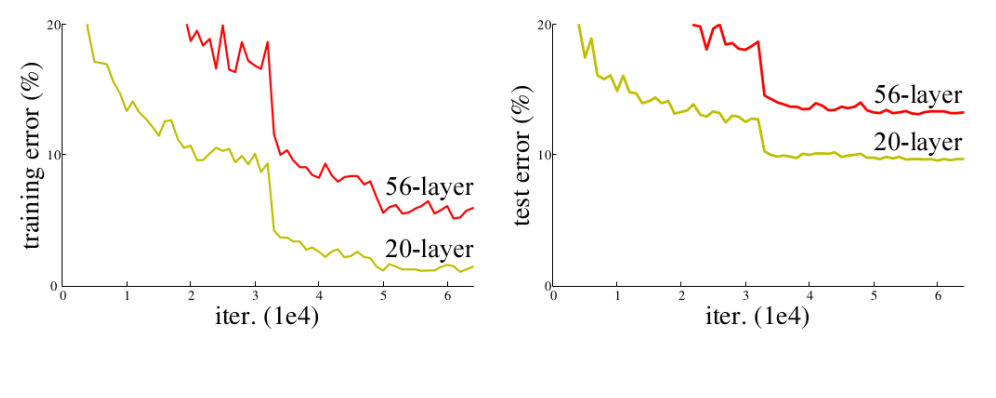
Train and test error for 20-layer and 56-layer NN

Another possible reason can be vanishing gradient and/or exploding gradient problems. However, the authors of ResNet (He et al.) argued that the use of Batch Normalization and proper initialization of weights through normalization ensures that the gradients have healthy norms. But, what went wrong here? Let’s understand this by construction.

Consider a shallow neural network that was trained on a dataset. Also, consider a deeper one in which the initial layers have the same weight matrices as the shallow network (the blue colored layers in the below diagram) with added some extra layers (green colored layers). We set the weight matrices of the added layers as identity matrices (identity mappings).

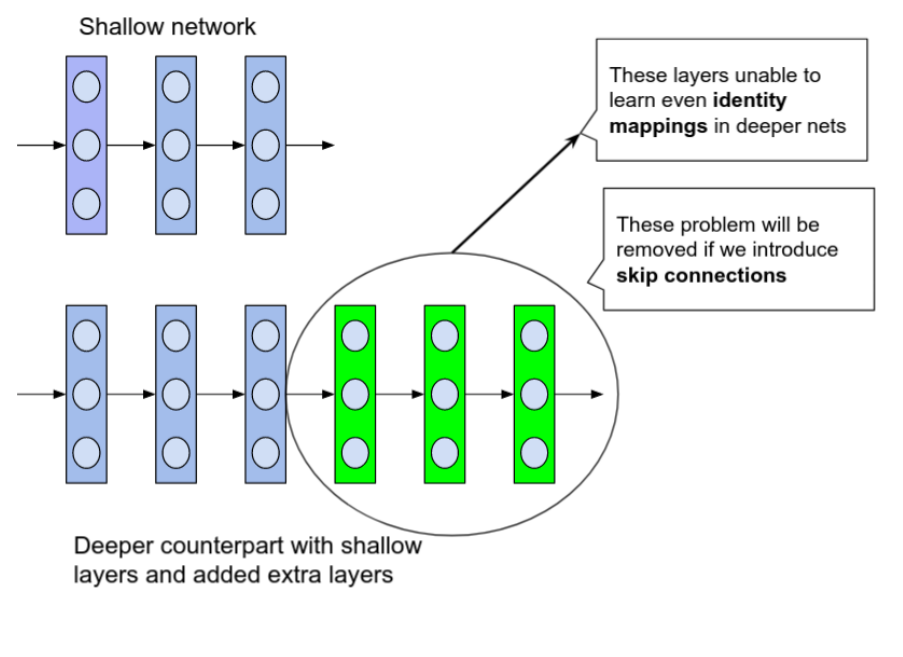

Diagram explaining the construction

From this construction, the deeper network should not produce any higher training error than its shallow counterpart because we are actually using the shallow model’s weight in the deeper network with added identity layers. But experiments prove that the deeper network produces high training error comparing to the shallow one. This states the inability of deeper layers to learn even identity mappings.

Variants of Skip Connections
In this section, we will see the variants of skip connections in different architectures. Skip Connections can be used in 2 fundamental ways in Neural Networks: Addition and Concatenation.

## IMPLEMENTING RESNET

In [4]:
# import required libraries
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
# basic resdidual block of ResNet
# This is generic in the sense, it could be used for downsampling of features.
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=[1, 1], downsample=None):
        """
        A basic residual block of ResNet
        Parameters
        ----------
            in_channels: Number of channels that the input have
            out_channels: Number of channels that the output have
            stride: strides in convolutional layers
            downsample: A callable to be applied before addition of residual mapping
        """
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride[0], 
            padding=1, bias=False
        )
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=stride[1], 
            padding=1, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        # applying a downsample function before adding it to the output
        if(self.downsample is not None):
            residual = downsample(residual)

        out = F.relu(self.bn(self.conv1(x)))
        
        out = self.bn(self.conv2(out))
        # note that adding residual before activation 
        out = out + residual
        out = F.relu(out)
        return out

In [5]:
# downsample using 1 * 1 convolution
downsample = nn.Sequential(
    nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
    nn.BatchNorm2d(128)
)
# First five layers of ResNet34
resnet_blocks = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
    nn.MaxPool2d(kernel_size=2, stride=2),
    ResidualBlock(64, 64),
    ResidualBlock(64, 64),
    ResidualBlock(64, 128, stride=[2, 1], downsample=downsample)
)

# checking the shape
inputs = torch.rand(1, 3, 100, 100) # single 100 * 100 color image
outputs = resnet_blocks(inputs)
print(outputs.shape)    # shape would be (1, 128, 13, 13)

torch.Size([1, 128, 13, 13])


In [6]:
# one could also use pretrained weights of ResNet trained on ImageNet
resnet34 = torchvision.models.resnet34(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [7]:
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## DenseNet – A dense block

In [8]:
class Dense_Layer(nn.Module):
    def __init__(self, in_channels, growthrate, bn_size):
        super(Dense_Layer, self).__init__()

        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(
            in_channels, bn_size * growthrate, kernel_size=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(bn_size * growthrate)
        self.conv2 = nn.Conv2d(
            bn_size * growthrate, growthrate, kernel_size=3, padding=1, bias=False
        )

    def forward(self, prev_features):
        out1 = torch.cat(prev_features, dim=1)
        out1 = self.conv1(F.relu(self.bn1(out1)))
        out2 = self.conv2(F.relu(self.bn2(out1)))
        return out2

In [9]:
class Dense_Block(nn.ModuleDict):
    def __init__(self, n_layers, in_channels, growthrate, bn_size):
        """
        A Dense block consists of `n_layers` of `Dense_Layer`
        Parameters
        ----------
            n_layers: Number of dense layers to be stacked 
            in_channels: Number of input channels for first layer in the block
            growthrate: Growth rate (k) as mentioned in DenseNet paper
            bn_size: Multiplicative factor for # of bottleneck layers
        """
        super(Dense_Block, self).__init__()

        layers = dict()
        for i in range(n_layers):
            layer = Dense_Layer(in_channels + i * growthrate, growthrate, bn_size)
            layers['dense{}'.format(i)] = layer
        
        self.block = nn.ModuleDict(layers)
    
    def forward(self, features):
        if(isinstance(features, torch.Tensor)):
            features = [features]
        
        for _, layer in self.block.items():
            new_features = layer(features)
            features.append(new_features)

        return torch.cat(features, dim=1)

In [10]:
# a block consists of initial conv layers followed by 6 dense layers
dense_block = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(3, 2),
    Dense_Block(6, 64, growthrate=32, bn_size=4),
)

inputs = torch.rand(1, 3, 100, 100)
outputs = dense_block(inputs)
print(outputs.shape)    # shape would be (1, 256, 24, 24)

# one could also use pretrained weights of DenseNet trained on ImageNet
densenet121 = torchvision.models.densenet121(pretrained=True)

torch.Size([1, 256, 24, 24])


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]